In [1]:
from random import randrange

import pandas as pd
import numpy as np
import altair as alt

from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1

# Carregando os dados - MNIST
Descrição do site de onde os dados são baixados:

"The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples"

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
print("Tamanho do vetor de dados:", mnist.data.shape)
print("Tamanho do vetor de alvos:", mnist.target.shape)

Tamanho do vetor de dados: (70000, 784)
Tamanho do vetor de alvos: (70000,)


## Separando o conjunto de treino e teste

- Vale ressaltar que o ideal, para garantir a generalização do modelo, é separar o conjunto de treinamento em "K folds", realizando uma validação cruzada. Para diminuir o tempo de execução e simplificar este tutorial, dividiremos apenas em 2 folds
- Além disso, o K-means pode ser sensível à inicialização aleatória dos clusters ou até mesmo da ordem em que os dados são apresentados para o algoritmo. Deste modo, uma boa prática seria executar o algoritmo algumas vezes variando ambas as condições, calcular a média dos centroides encontrados e, por fim, usar esta média como os centroides iniciais da última execução

- O conjunto de teste (últimas 10000 entradas), segundo a fonte, foi gerado de maneira independente do conjunto de treino

In [5]:
n_train_samples = 10000
n_test_samples = 1000

In [6]:
X_train = mnist.data[0:n_train_samples]
y_train = mnist.target[0:n_train_samples]

X_test = mnist.data[60000:60000 + n_test_samples]
y_test = mnist.target[60000:60000 + n_test_samples]
y_test_int = y_test.astype(int)

# Visualização dos dados

## Selecionando uma amostra aleatória

In [7]:
select = randrange(n_train_samples)
img = X_train[select]
img = img.reshape(28,28);

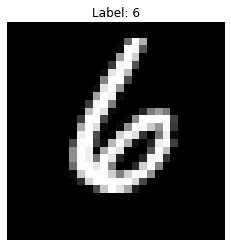

In [8]:
plt.figure()
plt.imshow(img,cmap='gray',interpolation="nearest")
plt.title("Label: %s" % y_train[select])
plt.axis('off');

# Pré-processamento
- Normalização (sim ou não?)

# K-means - 10 clusters

In [9]:
n_clusters = 10
kmeans_10 = KMeans(n_clusters=n_clusters).fit(X_train)

In [10]:
predicted_labels_10 = kmeans_10.predict(X_test)

# Visualizando os centroides

In [11]:
cluster_centers_10 = kmeans_10.cluster_centers_

## Definindo a label de cada um dos clusters
- Vamos descobrir qual é o dígito predominante em cada um dos clusters para entender se o K-means foi capaz de separar bem cada um dos dígitos em um cluster

Documentação:

numpy.bincount -> Count number of occurrences of each value in array of non-negative ints.


In [12]:
# criando uma lista com todos os IDs de clusters que foram previstos no conjunto de teste
id_clusters = np.unique(predicted_labels_10)

most_freq_10 = np.zeros(n_clusters) # inicializando o vetor que conterá os dígitos mais frequentes em cada cluster
for icluster in range(n_clusters):  
    # selecionando as labels das entradas que foram previstas como icluster
    labels = y_test_int[predicted_labels_10==id_clusters[icluster]]
    
    # selecionando qual a label foi mais frequente para este cluster (icluster)
    most_freq_10[icluster] = np.argmax(np.bincount(labels))

In [13]:
print(most_freq_10)

[1. 8. 4. 6. 1. 3. 0. 7. 7. 2.]


## Plotando o vetor que representa o centroide de cada cluster

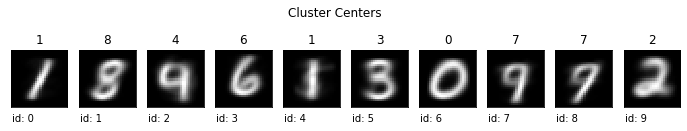

In [14]:
nrows = 1
ncols = n_clusters
irow = 0
icolumn = 0

fig, ax = plt.subplots(figsize=(12,4),nrows=nrows, ncols=ncols)

for cluster in range(n_clusters):
    img = cluster_centers_10[cluster];
    img = img.reshape(28,28);

    ax[icolumn].imshow(img, cmap='gray', interpolation="nearest")
    ax[icolumn].set_title(str(int(most_freq_10[cluster])))
    ax[icolumn].text(0, 35, 'id: %s' % cluster)
    
    ax[icolumn].get_xaxis().set_visible(False)
    ax[icolumn].get_yaxis().set_visible(False)
    
    icolumn = icolumn + 1

plt.suptitle('Cluster Centers', y=0.75);

# Visualização dos resultados - tSNE + Altair

In [15]:
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X_test)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.028s...
[t-SNE] Computed neighbors for 1000 samples in 1.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 502.251680
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.603966
[t-SNE] KL divergence after 1000 iterations: 1.079789


In [16]:
df_10 = pd.DataFrame()
df_10['tsne-2d-one'] = tsne_results[:,0]
df_10['tsne-2d-two'] = tsne_results[:,1]
df_10['label'] = y_test_int
df_10['cluster_id'] = predicted_labels_10
df_10['predicted'] = [int(most_freq_10[i]) for i in predicted_labels_10]
df_10['correct'] = df_10.apply(lambda x: x['predicted'] == x['label'], axis=1)

In [17]:
alt.Chart(df_10).mark_text().encode(
    text='label',
    x='tsne-2d-one',
    y='tsne-2d-two',
    color=alt.Color('predicted', type='nominal'),
    tooltip=['label', 'predicted']
).interactive()

alt.Chart(...)

Observar:
- 9 e 5 não tem clusters
- Confusão entre os dígitos 4 e 9
- Confusão entre os dígitos 3 e 8

# Aumentando o número de clusters para 20

In [18]:
n_clusters = 20
kmeans_20 = KMeans(n_clusters=n_clusters).fit(X_train)

In [19]:
predicted_labels_20 = kmeans_20.predict(X_test)

# Visualizando os centroides

In [20]:
cluster_centers_20 = kmeans_20.cluster_centers_

## Definindo a label de cada um dos clusters
- Vamos descobrir qual é o dígito predominante em cada um dos clusters para entender se o K-means foi capaz de separar bem cada um dos dígitos em um cluster

In [21]:
# criando uma lista com todos os IDs de clusters que foram previstos no conjunto de teste
id_clusters = np.unique(predicted_labels_20)

most_freq_20 = np.zeros(n_clusters) # inicializando o vetor que conterá os dígitos mais frequentes em cada cluster
for icluster in range(n_clusters):  
    # selecionando as labels das entradas que foram previstas como icluster
    labels = y_test_int[predicted_labels_20==id_clusters[icluster]]
    
    # selecionando qual a label foi mais frequente para este cluster (icluster)
    most_freq_20[icluster] = np.argmax(np.bincount(labels))

In [22]:
print(most_freq_20)

[7. 2. 2. 0. 5. 3. 1. 6. 0. 7. 3. 9. 1. 6. 4. 7. 1. 4. 8. 8.]


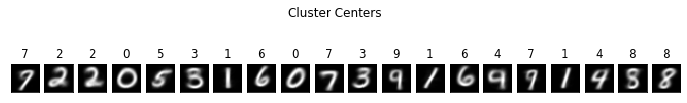

In [23]:
nrows = 1
ncols = n_clusters
irow = 0
icolumn = 0

fig, ax = plt.subplots(figsize=(12,4),nrows=nrows, ncols=ncols)

for cluster in range(n_clusters):
    img = cluster_centers_20[cluster];
    img = img.reshape(28,28);

    ax[icolumn].imshow(img,cmap='gray',interpolation="nearest")
    ax[icolumn].set_title("%s" % (int(most_freq_20[cluster])))
    ax[icolumn].get_xaxis().set_visible(False)
    ax[icolumn].get_yaxis().set_visible(False)
    
    icolumn = icolumn + 1

plt.suptitle('Cluster Centers', y=0.75);

# Visualização dos resultados para 20 clusters - tSNE + Altair

In [24]:
df_20 = pd.DataFrame()
df_20['tsne-2d-one'] = tsne_results[:,0]
df_20['tsne-2d-two'] = tsne_results[:,1]
df_20['label'] = y_test_int
df_20['cluster_id'] = predicted_labels_20
df_20['predicted'] = [int(most_freq_20[i]) for i in predicted_labels_20]
df_20['correct'] = df_20.apply(lambda x: x['predicted'] == x['label'], axis=1)

In [25]:
alt.Chart(df_20).mark_text().encode(
    text='label',
    x='tsne-2d-one',
    y='tsne-2d-two',
    color=alt.Color('predicted', type='nominal'),
    tooltip=['label', 'predicted']
).interactive()

alt.Chart(...)

# Calcular métricas 

## Dispersão intra cluster

In [26]:
kmeans_10.inertia_ > kmeans_20.inertia_

True

Há um decrescimento da distância intra cluster, aqui calculada com o método `inertia_`.
Da documentação:
> Sum of squared distances of samples to their closest cluster center.

## Índice silhueta

In [27]:
silhouette_10 = silhouette_score(X_test, predicted_labels_10)
silhouette_20 = silhouette_score(X_test, predicted_labels_20)

In [28]:
silhouette_10 < silhouette_20 

False

Há um crescimento do índice silhueta

Sugestão: calcular também o índice Davies–Bouldin

# Cálculo de acurácia 
- Apenas para fins didáticos, pois essa possibilidade não existiria para casos não supervisionados
- Assume-se que a label do cluster é a label da maioria dos dígitos neste cluster

In [29]:
def calculate_accuracy(y_true, y_pred, most_freq):
    """
    Parameters
    ----------
    y_true : array_like
             List of expected values
    y_pred : array_like
             List of predicted values
    most_freq: array_like
               List containing the most frequent(or the predominant) labels for each cluster ID
                
    Returns
    -------
    float
        Returns calculated accuracy
    """
    
    # most_freq contains the most frequents digits in each cluster
    count = 0;
    for ievent in range(len(y_true)):
        cluster_predict = y_pred[ievent].astype(int) # prediction
        if y_true[ievent]==most_freq[cluster_predict]:
            count = count+1
            
    accuracy = count/float(len(y_true))
    return accuracy

In [30]:
calculate_accuracy(y_test_int, predicted_labels_10, most_freq_10)

0.557

In [31]:
calculate_accuracy(y_test_int, predicted_labels_20, most_freq_20)

0.667

Para 20 clusters o K-means apresenta uma acurácia maior

# Sugestões de estudo
- Avaliar se a normalização tem algum impacto no resultado final
- Variar mais o número de clusters e plotar a curva das métricas
    - distâncias intra e extra cluster
    - índice silhueta
    - índice Davies-Bouldin
- Testar outros modelos não supervisionados
    - Rede ART
    - Camada ou Mapa de Kohonen